In [177]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

from PIL import Image
from pose_vector_to_transformation_matrix import \
    pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image
from undistort_image_vectorized import undistort_image_vectorized


In [178]:
# load camera poses

# each row i of matrix 'poses' contains the transformations that transforms
# points expressed in the world frame to
# points expressed in the camera frame

pose_vectors = np.loadtxt('data/poses.txt')

# load camera intrinsics
K = np.loadtxt('data/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('data/D.txt')  # distortion coefficients[2x1]

# load one image with a given index
img_index = 1
img = cv2.imread('data/images/img_{0:04d}.jpg'.format(img_index))
height, width, _ = img.shape

# project the corners on the image
# compute the 4x4 homogeneous transformation matrix that maps points
# from the world to the camera coordinate frame

T_C_W = pose_vector_to_transformation_matrix(pose_vectors[img_index - 1, :])

In [179]:
# define 3D corner positions
# [Nx3] matrix containing the corners of the checkerboard as 3D points
# (X,Y,Z), expressed in the world coordinate system

square_size = 0.04  # [m]
num_corners_x = 9
num_corners_y = 6
num_corners = num_corners_x * num_corners_y

X, Y = np.meshgrid(np.arange(num_corners_x), np.arange(num_corners_y))
p_W_corners = square_size * np.stack([X, Y],
                                        axis=-1).reshape([num_corners, 2])

# add z coordinate, set z=0
p_W_corners = np.concatenate(
    [p_W_corners, np.zeros([num_corners, 1])], axis=-1)


In [180]:
%matplotlib inline

# transform 3d points from world to current camera pose
p_C_corners = np.matmul(T_C_W[None, :, :],
                        np.concatenate([p_W_corners,
                                        np.ones([num_corners, 1])],
                                        axis=-1)[:, :, None]).squeeze(-1)
p_C_corners = p_C_corners[:, :3]

projected_pts = project_points(p_C_corners, K, D) 

In [181]:
print(projected_pts.shape)

(54, 3)


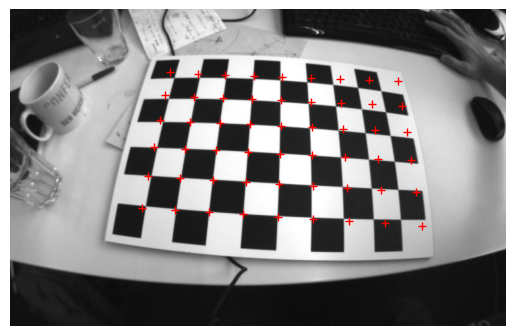

In [182]:
projected_pts = project_points(p_C_corners, K, D)
plt.imshow(img, cmap='gray')
plt.plot(projected_pts[:, 0], projected_pts[:, 1], 'r+')
plt.axis('off')

plt.show()

In [183]:
# undistort image with bilinear interpolation
start_t = time.time()
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)
print('Undistortion with bilinear interpolation completed in {}'.format(
    time.time() - start_t))

# vectorized undistortion without bilinear interpolation
start_t = time.time()
img_undistorted_vectorized = undistort_image_vectorized(img, K, D)
print('Vectorized undistortion completed in {}'.format(
    time.time() - start_t))


Undistortion with bilinear interpolation completed in 10.84363079071045
Vectorized undistortion completed in 0.026269197463989258


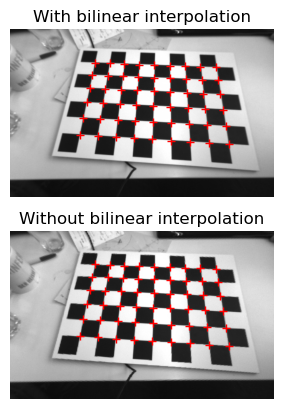

In [184]:
plt.clf()
plt.close()
fig, axs = plt.subplots(2)

# 
axs[0].imshow(img_undistorted, cmap='gray')
axs[0].plot(projected_pts[:, 0], projected_pts[:, 1], 'r+')
axs[0].set_axis_off()
axs[0].set_title('With bilinear interpolation')

# 
axs[1].imshow(img_undistorted_vectorized, cmap='gray')
axs[1].plot(projected_pts[:, 0], projected_pts[:, 1], 'r+')
axs[1].set_axis_off()
axs[1].set_title('Without bilinear interpolation')
plt.show()

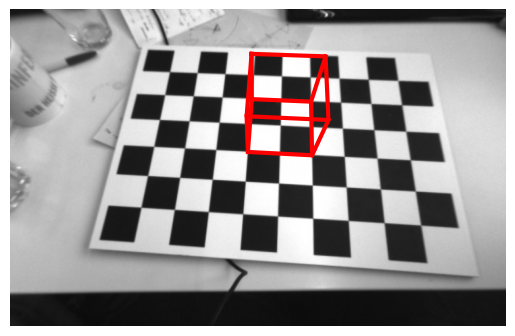

In [185]:
# calculate the cube points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
s = 2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([offset_x + X.flatten()*s,
                        offset_y + Y.flatten()*s,
                        Z.flatten()*s,
                        np.ones([8])], axis=-1)

p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([4, 1]))

# Plot the cube
plt.clf()
plt.close()
plt.imshow(img_undistorted, cmap='gray')

lw = 3

# base layer of the cube
plt.plot(cube_pts[[1, 3, 7, 5, 1], 0],
            cube_pts[[1, 3, 7, 5, 1], 1],
            'r-',
            linewidth=lw)

# top layer of the cube
plt.plot(cube_pts[[0, 2, 6, 4, 0], 0],
            cube_pts[[0, 2, 6, 4, 0], 1],
            'r-',
            linewidth=lw)

# # vertical lines
plt.plot(cube_pts[[0, 1], 0], cube_pts[[0, 1], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[2, 3], 0], cube_pts[[2, 3], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[4, 5], 0], cube_pts[[4, 5], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[6, 7], 0], cube_pts[[6, 7], 1], 'r-', linewidth=lw)

plt.axis('off')
plt.show()

In [186]:
cube_pts.shape

(8, 3)

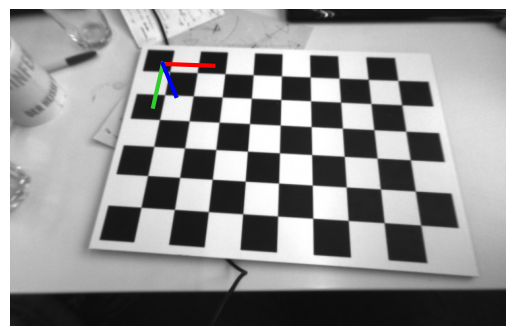

In [187]:
# TODO - 3 : Draw XYZ-coordinate
offset_x_coord = 0.04 * 3 * (1/8)
offset_y_coord = 0.04
s_coord = 3/2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([offset_x_coord + X.flatten()*s_coord,
                        offset_y_coord + Y.flatten()*s_coord,
                        Z.flatten()*s_coord,
                        np.ones([8])], axis=-1)

p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([4, 1]))

# Plot the cube
plt.clf()
plt.close()
plt.imshow(img_undistorted, cmap='gray')

lw = 3

# (red)
plt.plot(cube_pts[[0,2], 0],
            cube_pts[[0,2], 1],
            'r-',
            linewidth=lw)
# (green)
plt.plot(cube_pts[[0, 4], 0],
            cube_pts[[0, 4], 1],
            'limegreen',
            linewidth=lw)
# (blue)
plt.plot(cube_pts[[0, 1], 0], cube_pts[[0, 1], 1], 'b-', linewidth=lw)

plt.axis('off')
plt.show()

In [188]:
# Re-generate img_undistored
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

In [189]:
# calculate the cube points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
s = 2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))

p_W_cube = np.stack([
    offset_x + X.flatten()*s,
    offset_y + Y.flatten()*s,
    Z.flatten()*s,
    np.ones([8])], axis=-1)
p_W_cube = p_W_cube.reshape(8, 1, 4)

vertex_id = (
    0, 2, 6, 4, # base layer of the cube
    1, 3, 7, 5, # top layer of the cube
)

lines_id = (
    [0, 1], [2, 3], [4, 5], [6, 7], # vertical lines
    [0, 2], [2, 6], [6, 4], [4, 0], # base lines
    [1, 3], [3, 7], [7, 5], [5, 1], # top lines
)

# set points in world coordinate
num_pts_per_line = 50
weights = np.linspace(0, 1, num_pts_per_line)[..., None]
p_W_cube_all = np.zeros((num_pts_per_line * 12, 4))
for ii, line in enumerate(lines_id):
    indices = slice(ii * num_pts_per_line, (ii + 1) * num_pts_per_line)
    p_W_cube_all[indices] = (weights * p_W_cube[line[0]] + (1 - weights) * p_W_cube[line[1]]).reshape(-1, 4)


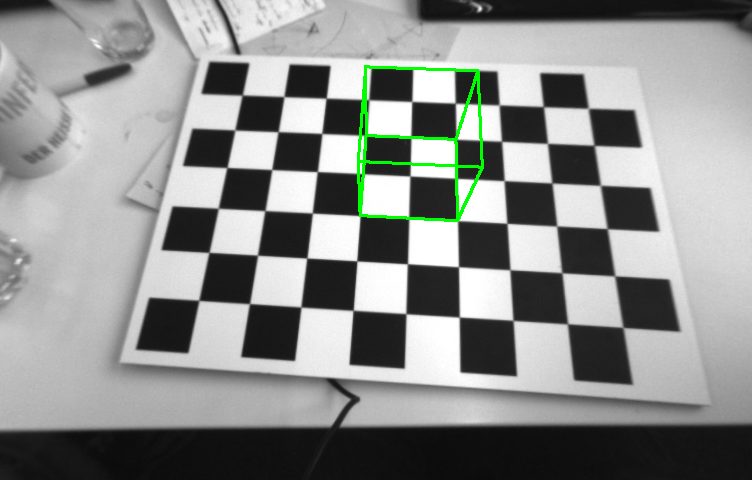

In [190]:
# project on image coordinate
p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube_all[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([4, 1]))
cube_pts_int = cube_pts.astype(int)
cube_pts_int = np.unique(cube_pts_int, axis=0)

# draw points
for i, (x, y, z) in enumerate(cube_pts_int):
    for iy in range(-1, 2):
        for ix in range(-1, 2):
            img_undistorted[y+iy, x+ix] = (0, 255, 0)

Image.fromarray(img_undistorted)

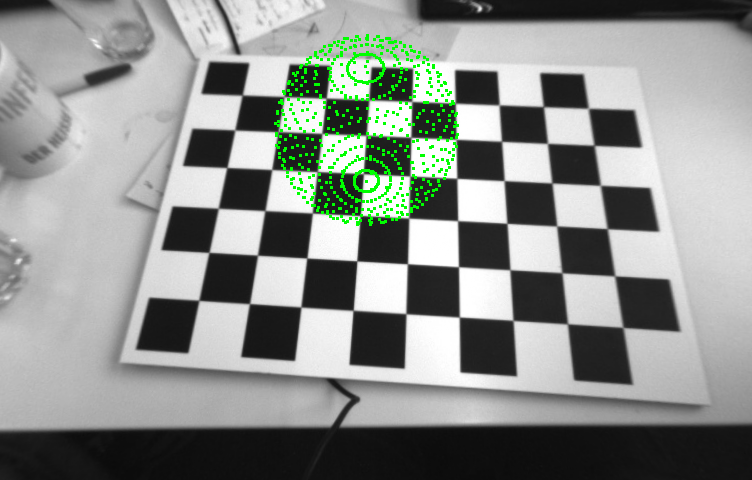

In [191]:
# TODO - 4 : Augment a sphere instead of cube 

# Re-generate img_undistored
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)

# calculate the sphere points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
radius = 0.04 * 2

# Define latitude (theta) and longitude (phi)
num_latitudes = 20  
num_longitudes = 40 

theta = np.linspace(0, np.pi, num_latitudes)  # [0, π]
phi = np.linspace(0, 2 * np.pi, num_longitudes)  # [0, 2π]
theta, phi = np.meshgrid(theta, phi)

# Convert spherical to Cartesian coordinates
X = offset_x + radius * np.sin(theta) * np.cos(phi)
Y = offset_y + radius * np.sin(theta) * np.sin(phi)
Z = radius * np.cos(theta)

# Combine points into homogeneous coordinates
p_W_sph = np.stack([X.flatten(), Y.flatten(), Z.flatten(), np.ones(X.size)], axis=-1)

# Project points onto image coordinates
p_C_sph = np.matmul(T_C_W[None, :, :], p_W_sph[:, :, None]).squeeze(-1)
p_C_sph = p_C_sph[:, :3]

sph_pts = project_points(p_C_sph, K, np.zeros([4, 1]))
sph_pts_int = sph_pts.astype(int)
sph_pts_int = np.unique(sph_pts_int, axis=0)

# Draw points on the image
for i, (x, y, z) in enumerate(sph_pts_int):
    for iy in range(-1, 2):
        for ix in range(-1, 2):
            img_undistorted[y+iy, x+ix] = (0, 255, 0)

Image.fromarray(img_undistorted)
